In [819]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate 
from scipy import integrate

cos = np.cos
sin = np.sin
pi = np.pi

# Question 1

In [820]:
def simple_integrate(fun,a,b,tol):
    x=np.linspace(a,b,5);
    dx=(b-a)/4.0;
    #np.median(np.diff(x))
    y=fun(x);
    neval=len(x) #let's keep track of function evaluations
    f1=(y[0]+4*y[2]+y[4])/6.0*(b-a);
    f2=(y[0]+4*y[1]+2*y[2]+4*y[3]+y[4])/12.0*(b-a);
    myerr=np.abs(f2-f1)
    if (myerr<tol):
        #return (f2)/1.0,myerr,neval
        return (16.0*f2-f1)/15.0,myerr,neval;
    else:
        mid=0.5*(b+a);
        f_left,err_left,neval_left=simple_integrate(fun,a,mid,tol/2.0);
        f_right,err_right,neval_right=simple_integrate(fun,mid,b,tol/2.0);
        neval=neval+neval_left+neval_right;
        f=f_left+f_right;
        err=err_left+err_right;
        return f,err,neval;

In [821]:
# my improved recursive integartor 
def improve_integrate(func,a,b,tol):
    x = np.linspace(a, b, 5)  
    
    # These guys wont change throughout the recursion so 
    y_a = func(x[0])
    y_b = func(x[4])
    y_mid = func(x[2])
    
    # Number of evaluation (neval sounds so weird...)
    count = 3
    
    # Recursion part of the integration
    ansF, errF, countF = recursion(func, a, b, y_a, y_b, y_mid, count, tol) #calling the recursive function
    return ansF, errF, countF
    
    
def recursion(func, a, b, y_a, y_b, y_mid, count, tol):
    #In case of a new recursion cycle, x will be redistributed and the middle points will need to be recalculated
    x = np.linspace(a, b, 5)
    ##Now when there is a recursion, we need to update 3 values (y_mid, y_midL, y_midR)
    y_mid = func(x[2])
    y_midL = func(x[1])
    y_midR = func(x[3])
    count = 3
        
    ## Now we evaluate f1 and f2:
    f1 = (y_a + 4*y_mid + y_b)/6.0*(b-a)
    f2 = (y_a + 4*y_midL + 2*y_mid + 4*y_midR + y_b)/12.0*(b-a)
    err = np.abs(f1 - f2)
    
    if err>tol:
        mid = (a + b)/2
        ansL, errL, countL = recursion(func, a, mid, y_a, y_mid, y_midL, count, tol/2) 
        ansR, errR, countR = recursion(func, mid, b, y_mid, y_b, y_midR, count, tol/2)
        count = count + countL + countR
        err = errL + errR  
        ans = ansL + ansR
        return ans, err, count
    else:
        ans = (16.0*f2-f1)/15.0
        return ans, err, count

In [822]:
def func1(x):
    return np.cos(x)

In [823]:
f_better, err_better, neval_better = improve_integrate(func1, -1, 2, 1e-3)
f_simple, err_simple, neval_simple = simple_integrate(func1, -1, 2, 1e-3)

In [824]:
print('Number of function evaluation for the better routine is: ',neval_better)

Number of function evaluation for the better routine is:  21


In [825]:
print('Number of function evaluation for the routine in class is: ',neval_simple)

Number of function evaluation for the routine in class is:  35


# Question 2

We need to figure out how to convert the range from 0.5 to 1 to the range in the basis of the Chebyshev functions. We will do that by assuming a linear transformation relation: x_cheb = a*x_real + b. We know that the Chebysev has upper bound and lower bound 1 and -1, respectively. With that information, combining with the given range of we have for the real value of x, we can find a transformation that map from x_real to x_cheb

In [826]:
def conversion(x):
    # x_cheb_max = a*x_real_max + b
    # x_cheb_min = a*x_real_min + b
    x_cheb_max = 1
    x_cheb_min = -1
    a = (x_cheb_max - x_cheb_min)/(max(x) - min(x))
    b = x_cheb_max - a*max(x)
    x_cheb = a*x + b
    return x_cheb

In [827]:
# This is from cheb_expand.py, with modified input x_real to x_cheb
def cheb_mat_uniform(x_real,order):
    x = conversion(x_real)
    nx = len(x)
    mat = np.zeros([nx, order + 1])
    mat[:,0] = 1.0
    if order > 0:
        mat[:,1]=x
    if order > 1:
        for i in range(1,order):
            mat[:,i+1] = 2 * x * mat[:,i] - mat[:,i-1]
    return mat

We are going for a linear least squared fit. We will use SVD to complete this like in class

In [828]:
# Stole this from class
def fitting(x, A):
    U, S, V = np.linalg.svd(A,0)
    S = np.diag(1/S)
    fitp = V.T@S@U.T@x
    return fitp

In [829]:
# Now do the Chebyshev
x = np.linspace(0.5, 1, 101)
y = np.log2(x)
order = 50
A = cheb_mat_uniform(x, order)
param = fitting(y, A) # fitting parameter
pred = np.dot(A, param)

In [830]:
# Truncated Chebyshev 
n_trunc = 1
y_cheb = A[:,:n_trunc]@param[:n_trunc] # Calculate our prediction using this truncated Chebyshev
while abs(max(y_cheb - y)) > 1e-6 and n_trunc < order:
    n_trunc = n_trunc + 1
    y_cheb = A[:,:n_trunc]@param[:n_trunc]

In [844]:
print('Truncation n_trunc = ', n_trunc, ' will give a max error = ', abs(max(y_cheb - y)),
      ' which is smaller than 1e-6')
print('We can keep up to ', n_trunc - 1, 'th term for this error to be smaller than 1e-6')

Truncation n_trunc =  8  will give a max error =  3.1969811686849425e-07  which is smaller than 1e-6
We can keep up to  7 th term for this error to be smaller than 1e-6


In [845]:
# Poly Fit
coeffs = np.polyfit(x, y, n_trunc - 1)
coeffs = coeffs[::-1] # Have to reverse it because the coefficients are going from high to low order
y_poly = 0
for i in range(len(coeffs)):
    y_poly = y_poly + coeffs[i]*x**i

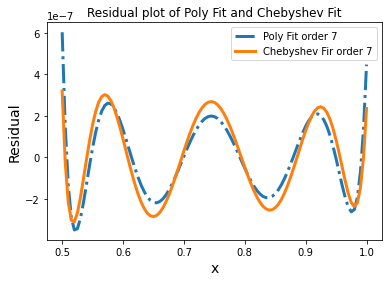

In [846]:
# Comparing Poly Fit and Truncated Chebyshev
err_poly = y_poly - y
err_cheb = y_cheb - y
plt.plot(x, err_poly, '-.', label = 'Poly Fit order 7', linewidth = 3)
plt.plot(x, err_cheb, label = 'Chebyshev Fir order 7', linewidth = 3)
plt.legend()
plt.title('Residual plot of Poly Fit and Chebyshev Fit')
plt.xlabel('x', fontsize = 14)
plt.ylabel('Residual', fontsize = 14)
plt.show()

In [834]:
std_poly = np.std(err_poly)
std_cheb = np.std(err_cheb)
max_err_poly = max(abs(err_poly))
max_err_cheb = max(abs(err_cheb))
print('RMS for Poly Fit is: ', std_poly)
print('RMS for Chebyshev Fit is: ', std_cheb)
print('Max error for Poly Fit is: ', max_err_poly)
print('Max error for Chebyshev Fit is: ', max_err_cheb)

RMS for Poly Fit is:  1.798906951595481e-07
RMS for Chebyshev Fit is:  1.9377247223753383e-07
Max error for Poly Fit is:  6.023577818758952e-07
Max error for Chebyshev Fit is:  3.1969811686849425e-07


Max error for Poly is higher than that of Chebyshev but it's the opposite with RMS

# Question 3

In [847]:
# Define a function for the chain decay
def decay(x, y):
    half_life = [1.409e17, 2.082e6, 402, 7.7421e12, 2.377e12, 5.046e10, 
             0.33e6, 186, 1608, 1194, 0.1643, 0.703e9, 1.5815e11, 11.95e6] # in second
    num = len(half_life) + 1
    dydx = np.zeros(num)
    
    for i in range(num):
        if i == 0:
            dydx[0] = -y[0]/half_life[0]
        elif i == num-1:
            dydx[i] = y[i-1]/half_life[i-1]
        else:
            dydx[i] = -y[i]/half_life[i] + y[i-1]/half_life[i-1]
    return dydx

In [836]:
# Value of y
y0 = np.asarray(np.zeros(15))
y0[0] = 1

Part a

In [837]:
## To cover the half life of U238
t0 = 0
t1 = 1e25
ansA = integrate.solve_ivp(decay, [t0, t1], y0, method = "Radau")

In [838]:
u238 = ansA.y[0,:] # This is the time evolution of U238
pb208 = ansA.y[-1,:] # This is the time evolution of Pb208

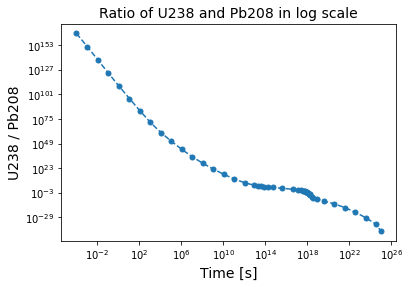

In [839]:
plt.clf()
plt.plot(ansA.t[1:], u238[1:]/pb208[1:], '--.', markersize = 10)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time [s]", fontsize = 14)
plt.ylabel("U238 / Pb208", fontsize = 14)
plt.title("Ratio of U238 and Pb208 in log scale", fontsize = 14)
plt.show() # This does agree with analytical solution

Part b

In [840]:
## To cover the half life of U238
t0 = 0
t1 = 1e25
ansB = integrate.solve_ivp(decay, [t0, t1], y0, method = "Radau")

In [841]:
u234 = ansB.y[3,:] # This is the time evolution of U234
th230 = ansB.y[4,:] # This is the time evolution of Th230

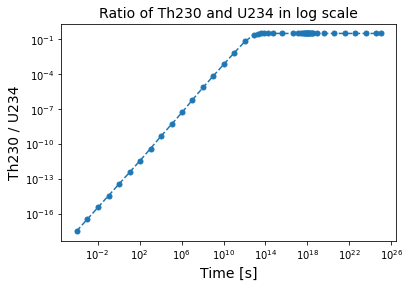

In [842]:
plt.clf()
plt.plot(ansB.t[1:], th230[1:]/u234[1:], '--.', markersize = 10)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time [s]", fontsize = 14)
plt.ylabel("Th230 / U234", fontsize = 14)
plt.title("Ratio of Th230 and U234 in log scale", fontsize = 14)
plt.show()